In [1]:
#라이브러리 추가
import pandas as pd
import matplotlib.pyplot as plt
#그래프 한글 폰트 설정(win)
from matplotlib import font_manager, rc
font_name = font_manager.FontProperties(fname="c:/Windows/Fonts/malgun.ttf").get_name()
rc('font', family=font_name)
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report


In [2]:
#csv 파일 불러오기
train = pd.read_csv('C:/Users/user/OneDrive/문서/MLData/open/train.csv') #학습데이터 
test = pd.read_csv('C:/Users/user/OneDrive/문서/MLData/open/test.csv') #테스트데이터
#URL은 0이 정상 1이 악성
#데이터 확인
print(train.head())
print(train.info())


FileNotFoundError: [Errno 2] No such file or directory: 'C:/Users/user/OneDrive/문서/MLData/open/train.csv'

In [3]:
# URL에 [.] -> . 으로 변경
train['URL'] = train['URL'].str.replace('[.]', '.')
test['URL'] = test['URL'].str.replace('[.]', '.')

print(train.head())
print(test.head())


              ID                                URL  label
0  TRAIN_0000000                 poznan.wuoz.gov.pl      0
1  TRAIN_0000001                vill.okawa.kochi.jp      0
2  TRAIN_0000002              nationalfinance.co.om      0
3  TRAIN_0000003             town.ozora.hokkaido.jp      0
4  TRAIN_0000004  open24.ie-news.irish/online/Login      1
             ID                                    URL
0  TEST_0000000             niquelarte.blogspot.com.es
1  TEST_0000001              northernmetalproducts.com
2  TEST_0000002                                  ga.de
3  TEST_0000003  florawww.eeb.uconn.edu/199300089.html
4  TEST_0000004                      activecity.moscow


label
0    5430159
1    1564897
Name: count, dtype: int64


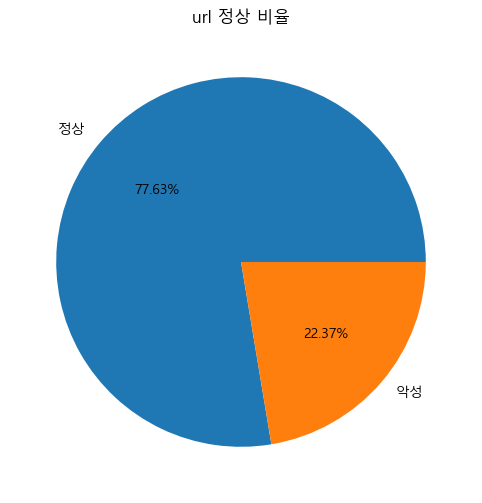

In [4]:
# URL 양성, 악성 비율 확인
print(train['label'].value_counts())

'''
0    5430159
1    1564897
'''
#원형 그래프로 표현
plt.figure(figsize=(8, 6))
train['label'].value_counts().plot(kind='pie', autopct='%1.2f%%',labels=['정상', '악성'])
plt.title('url 정상 비율')
plt.ylabel('')
plt.show()


In [5]:
# 악성 url 특징 찾기

mal_url = train[train['label'] == 1]['URL']
print(mal_url.head())
print(mal_url.tail())

#악성 url의 길이
mal_url_len = mal_url.apply(len)
print(mal_url_len.head())
print(mal_url_len.tail())




4                    open24.ie-news.irish/online/Login
5                                   93fm.radio.br/file
6     ps.com.vu/wp-config/wp-incluides/soft/ursnbxmmvd
9                          165.232.173.145/mobile.html
12                                         apollo.baby
Name: URL, dtype: object
6995033                      posts-8012419782.smarttechno.hr
6995044                                            rthe.top/
6995047                                www2.ml.meiceaord.com
6995050                            10rtggdoffice.duckdns.org
6995053    employeesalaryschedule70.000webhostapp.com/adb...
Name: URL, dtype: object
4     33
5     18
6     48
9     27
12    11
Name: URL, dtype: int64
6995033    31
6995044     9
6995047    21
6995050    25
6995053    50
Name: URL, dtype: int64


url 최대 길이: 8394
6415329    8394
4927421    8250
3375530    8118
1478572    7990
211219     6089
1101822    5127
2653952    5127
5368281    5127
5371953    5127
3282879    5089
Name: URL, dtype: int64


Text(0.5, 1.0, '악성 url 길이 분포')

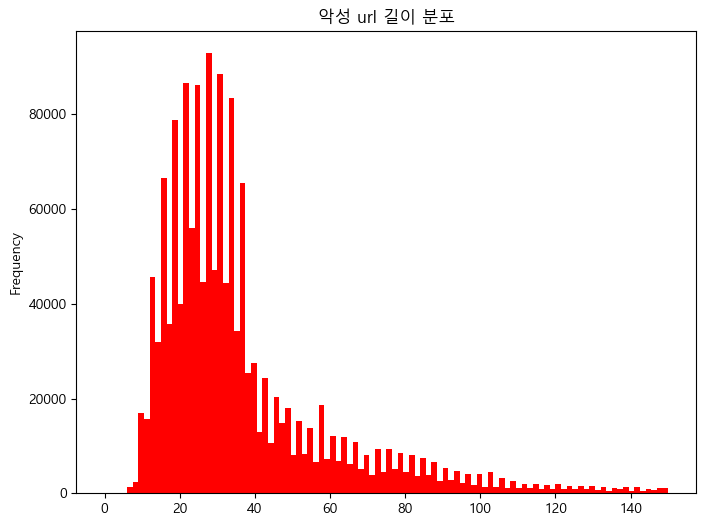

In [6]:
#악성 url 최대 길이
print('url 최대 길이:',mal_url_len.max())
#악성 url 길이 긴 url 10개 출력
print(mal_url_len.nlargest(10))

#악성 url 길이 분포
plt.figure(figsize=(8, 6))
mal_url_len.plot(kind='hist', bins=100, color='r',range=(0, 150))
plt.title('악성 url 길이 분포')

In [7]:
#정상 url 특정 찾기
nor_url = train[train['label'] == 0]['URL']
print(nor_url.head())
print(nor_url.tail())

#정상 url의 길이
nor_url_len = nor_url.apply(len)
print(nor_url_len.head())
print(nor_url_len.tail())

0        poznan.wuoz.gov.pl
1       vill.okawa.kochi.jp
2     nationalfinance.co.om
3    town.ozora.hokkaido.jp
7                  rih.p.se
Name: URL, dtype: object
6995049        henrik-schupp.de
6995051              ddht.co.kr
6995052    www.upstartepoxy.com
6995054          dekalbtool.com
6995055      helpinganimals.com
Name: URL, dtype: object
0    18
1    19
2    21
3    22
7     8
Name: URL, dtype: int64
6995049    16
6995051    10
6995052    20
6995054    14
6995055    18
Name: URL, dtype: int64


url 최대 길이: 820
3167484    820
6605111    794
3308616    714
5812147    680
744736     679
          ... 
1019149    584
1489347    584
2000472    584
2064769    584
2306705    584
Name: URL, Length: 100, dtype: int64


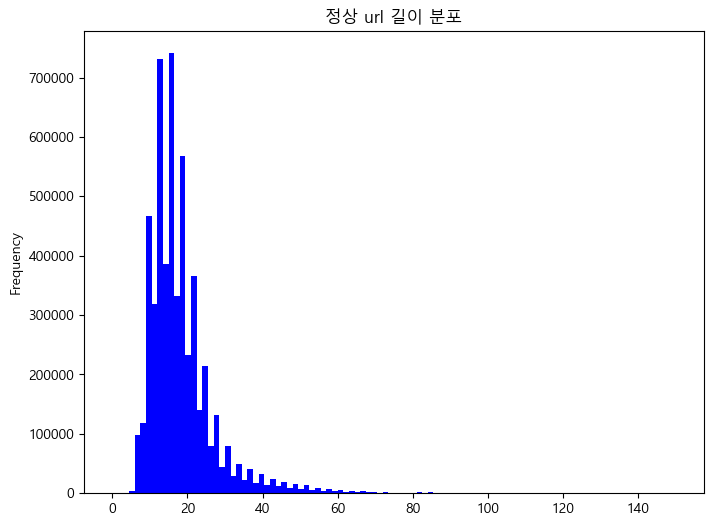

In [8]:
#정상 url 최대 길이
print('url 최대 길이:',nor_url_len.max()) 
#정상 url 길이 긴 url 10개 출력
print(nor_url_len.nlargest(100))

plt.figure(figsize=(8, 6))
nor_url_len.plot(kind='hist', bins=100, color='b',range=(0, 150))
plt.title('정상 url 길이 분포')
plt.show()

4     5
5     3
6     8
9     5
12    1
Name: URL, dtype: int64
6995033    3
6995044    2
6995047    3
6995050    2
6995053    4
Name: URL, dtype: int64
평균: 5.279833113617062


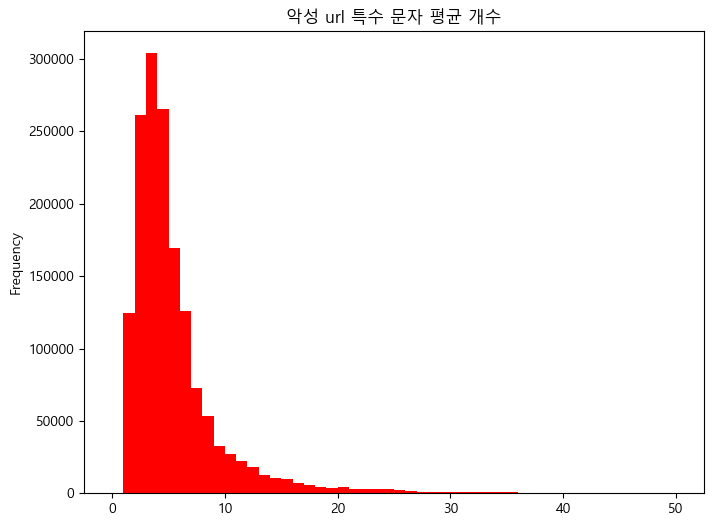

In [9]:
#특수 문자 포함 확인
#악성 url 특수 문자 평균 개수
mal_special = mal_url.str.count(r'[^a-zA-Z0-9]')
print(mal_special.head())
print(mal_special.tail())
print('평균:',mal_special.mean())
#그래프로 표현
plt.figure(figsize=(8, 6))
mal_special.plot(kind='hist', bins=50, color='r',range=(0, 50))
plt.title('악성 url 특수 문자 평균 개수')
plt.show()


0    3
1    3
2    2
3    3
7    2
Name: URL, dtype: int64
6995049    2
6995051    2
6995052    2
6995054    1
6995055    1
Name: URL, dtype: int64
평균: 1.9355773928535058


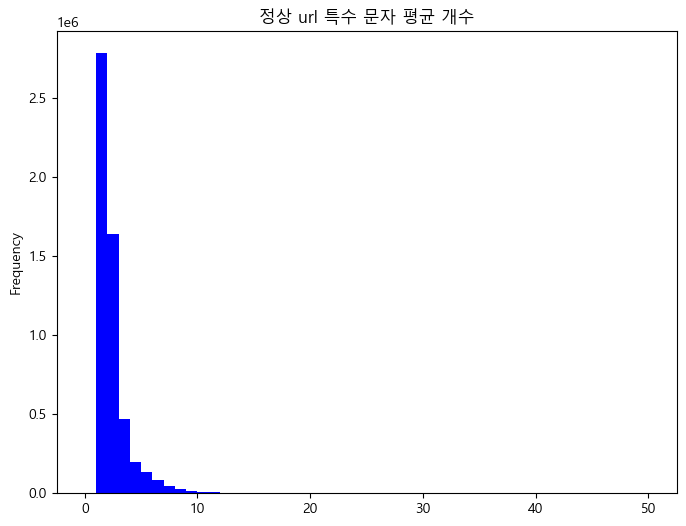

In [10]:
#양성 url 특수 문자 평균 개수
nor_special = nor_url.str.count(r'[^a-zA-Z0-9]')
print(nor_special.head())
print(nor_special.tail())
print('평균:',nor_special.mean())
#그래프로 표현
plt.figure(figsize=(8, 6))
nor_special.plot(kind='hist', bins=50, color='b',range=(0, 50))
plt.title('정상 url 특수 문자 평균 개수')
plt.show()

url 길이기 비정상적으로 길면 악성 url로 인식을 할 수 있을거 같다.
url 에 특수문자도 평균 악성 5개 양성 2개


In [11]:
#전체 url 길이가 200자 이상인 데이터 확인
print(train[train['URL'].apply(len) > 100]['label'].value_counts())
#악성 url이 200자 이상인 데이터 확인
print(train[(train['URL'].apply(len) < 100) & (train['label'] == 1)].shape[0])
#정상 url이 200자 이상인 데이터 확인
print(train[(train['URL'].apply(len) < 100) & (train['label'] == 0)].shape[0])

label
1    106031
0      3868
Name: count, dtype: int64
1457368
5426194


4     25.0
5     13.0
6     40.0
9     10.0
12    10.0
Name: URL, dtype: float64
6995033    18.0
6995044     7.0
6995047    17.0
6995050    21.0
6995053    41.0
Name: URL, dtype: float64
평균: 27.152615649711972


Text(0, 0.5, 'URL 개수')

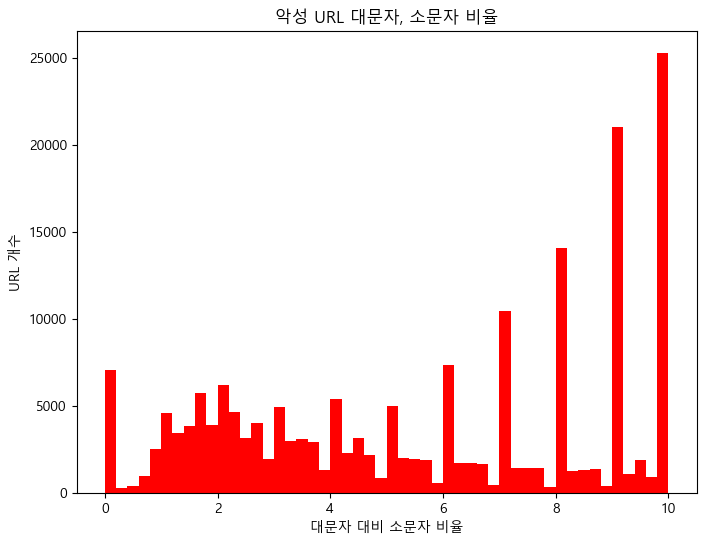

In [12]:
# 대문자, 소문자 비율 확인
mal_lower = mal_url.str.count(r'[a-z]')
mal_upper = mal_url.str.count(r'[A-Z]')

# 대문자가 없는 경우를 1로 대체하여 무한대 방지
mal_upper = mal_upper.replace(0, 1)

# 대문자, 소문자 비율 계산
mal_ratio = mal_lower / mal_upper

print(mal_ratio.head())
print(mal_ratio.tail())
print('평균:', mal_ratio.mean())

# 그래프로 표현
plt.figure(figsize=(8, 6))
mal_ratio.plot(kind='hist', bins=50, color='r', range=(0, 10))
plt.title('악성 URL 대문자, 소문자 비율')
plt.xlabel('대문자 대비 소문자 비율')
plt.ylabel('URL 개수')


0    15.0
1    16.0
2    19.0
3    19.0
7     6.0
Name: URL, dtype: float64
6995049    14.0
6995051     8.0
6995052    18.0
6995054    13.0
6995055    17.0
Name: URL, dtype: float64
평균: 15.915163266803939


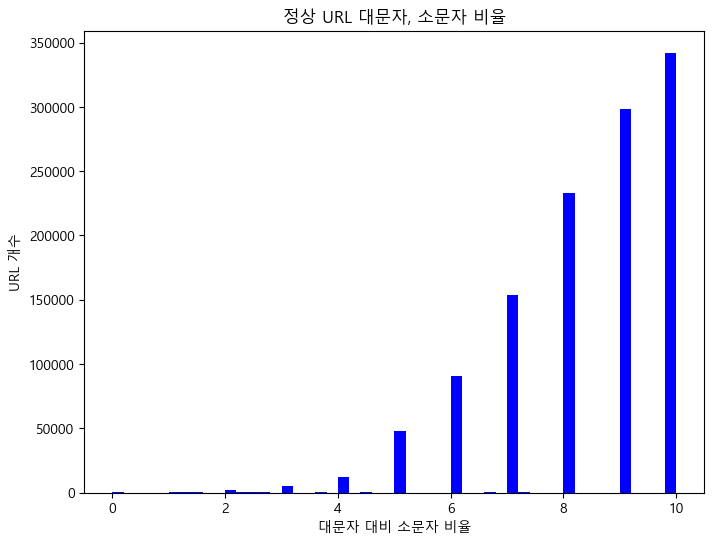

In [13]:
# 양성 데이터 대문자, 소문자 비율 확인
nor_lower = nor_url.str.count(r'[a-z]')
nor_upper = nor_url.str.count(r'[A-Z]')
nor_upper = nor_upper.replace(0, 1)
nor_ratio = nor_lower / nor_upper

print(nor_ratio.head())
print(nor_ratio.tail())
print('평균:', nor_ratio.mean())
# 그래프로 표현
plt.figure(figsize=(8, 6))
nor_ratio.plot(kind='hist', bins=50, color='b', range=(0, 10))
plt.title('정상 URL 대문자, 소문자 비율')
plt.xlabel('대문자 대비 소문자 비율')
plt.ylabel('URL 개수')
plt.show()

In [14]:
#알아낸 특징을 통해 데이터 전처리1
#데이터 결측치 확인
print(train.isnull().sum()) #결측치 없음
#데이터 중복 확인
print(train.duplicated().sum()) #중복값 확인
#url 길이가 비 정상적인 데이터 제거 후 확인
train = train[train['URL'].apply(len) < 100]
print(train['label'].value_counts())



ID       0
URL      0
label    0
dtype: int64
0
label
0    5426194
1    1457368
Name: count, dtype: int64


In [15]:
#전처리2
#URL 특수문자 개수가 5개 이상인 정상 url 제거 후 확인
train = train[(train['URL'].str.count(r'[^a-zA-Z0-9]') < 5) | (train['label'] == 1)] 
print(train['label'].value_counts())

label
0    5093860
1    1457368
Name: count, dtype: int64


In [16]:
#전처리3

# 대문자, 소문자 비율이 5 이하인 데이터 제거 후 확인
train = train[(train['URL'].str.count(r'[a-z]') / train['URL'].str.count(r'[A-Z]').replace(0, 1) > 6) | (train['label'] == 1)]
print(train['label'].value_counts())


label
0    4936036
1    1457368
Name: count, dtype: int64


In [17]:
# 특성과 레이블 분리
X = train['URL']
y = train['label']

# CountVectorizer를 사용하여 텍스트 데이터를 벡터화
vectorizer = CountVectorizer()
X_vectorized = vectorizer.fit_transform(X)

# 데이터 분할 (학습 데이터와 테스트 데이터)
X_train, X_test, y_train, y_test = train_test_split(X_vectorized, y, test_size=0.2, random_state=42)

# 나이브 베이즈 모델 학습
nb_model = MultinomialNB()
nb_model.fit(X_train, y_train)

# 예측
y_pred_nb = nb_model.predict(X_test)

# 정확도 평가
accuracy_nb = accuracy_score(y_test, y_pred_nb)
print(f'나이브 베이즈 정확도: {accuracy_nb:.2f}')

# 분류 보고서 출력
print("나이브 베이즈 분류 보고서:")
print(classification_report(y_test, y_pred_nb))

# 교차 검증을 사용한 모델 평가
cv_scores = cross_val_score(nb_model, X_vectorized, y, cv=5)
print(f'교차 검증 정확도: {cv_scores.mean():.2f})')

#데이터 전 처리2 까지 했을 때 : 0.94 정확도 측정 

나이브 베이즈 정확도: 0.94
나이브 베이즈 분류 보고서:
              precision    recall  f1-score   support

           0       0.95      0.98      0.96    986876
           1       0.93      0.81      0.87    291805

    accuracy                           0.94   1278681
   macro avg       0.94      0.90      0.92   1278681
weighted avg       0.94      0.94      0.94   1278681

교차 검증 정확도: 0.94)


In [ ]:
# 하이퍼파라미터 튜닝을 위한 GridSearchCV 설정
param_grid = {
    'alpha': [0.01, 0.1, 1, 10, 100]
}
grid_search = GridSearchCV(MultinomialNB(), param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_vectorized, y)

# 최적의 하이퍼파라미터 출력
print(f'최적의 하이퍼파라미터: {grid_search.best_params_}')

# 최적의 모델로 예측
best_nb_model = grid_search.best_estimator_
y_pred_best_nb = best_nb_model.predict(X_test)

# 최적의 모델 정확도 평가
accuracy_best_nb = accuracy_score(y_test, y_pred_best_nb)
print(f'최적의 나이브 베이즈 정확도: {accuracy_best_nb:.2f}')

# 최적의 모델 분류 보고서 출력
print("최적의 나이브 베이즈 분류 보고서:")
print(classification_report(y_test, y_pred_best_nb))

최적의 하이퍼파라미터: {'alpha': 0.1}


ValueError: could not convert string to float: 'niquelarte.blogspot.com.es'

In [19]:
print(test.head())
#테스트 데이터 결측치 확인
print(test.isnull().sum())
#테스트 데이터 중복 확인
print(test.duplicated().sum())


             ID                                    URL
0  TEST_0000000             niquelarte.blogspot.com.es
1  TEST_0000001              northernmetalproducts.com
2  TEST_0000002                                  ga.de
3  TEST_0000003  florawww.eeb.uconn.edu/199300089.html
4  TEST_0000004                      activecity.moscow
ID     0
URL    0
dtype: int64
0


In [20]:
# 특성과 레이블 분리
X_train = train['URL']
y_train = train['label']
X_test = test['URL']

# CountVectorizer를 사용하여 텍스트 데이터를 벡터화
vectorizer = CountVectorizer()
X_train_vectorized = vectorizer.fit_transform(X_train)
X_test_vectorized = vectorizer.transform(X_test)

# 나이브 베이즈 모델 학습
nb_model = MultinomialNB()
nb_model.fit(X_train_vectorized, y_train)

# 예측
test['probability'] = nb_model.predict(X_test_vectorized)

# 예측 결과 URL열 삭제 후 probability 열 추가
test.drop('URL', axis=1, inplace=True)
test.to_csv('C:/Users/user/OneDrive/문서/MLData/open/test_with_predictions3.csv', index=False)

# 예측 결과 확인
print(test.head())

             ID  probability
0  TEST_0000000            0
1  TEST_0000001            0
2  TEST_0000002            0
3  TEST_0000003            0
4  TEST_0000004            0
